In [1]:
import json

import torch
import numpy as np
import matplotlib.pyplot as plt

from torchvision.transforms import functional as TF

from src import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def load_config(config_file_path):
    with open(config_file_path, "r") as f:
        config = json.load(f)

    return config

In [4]:
def load_model(model_config, exp_info, device):
    weights_path  = f"./mlruns/{exp_info['exp_id']}/{exp_info['run_id']}/checkpoints/{exp_info['ckpt']}"

    model_dict = torch.load(weights_path, map_location='cpu')

    state_dict = {}

    for key in model_dict['state_dict'].keys():    
        state_dict[key.split('model.')[-1]] = model_dict['state_dict'][key]

    
    yolo_model = YOLOV1(model_config)
    yolo_model.load_state_dict(state_dict)
    yolo_model = yolo_model.to(device)
    yolo_model = yolo_model.eval()

    return yolo_model

In [5]:
def convert_yolo_pred_x1y1x2y2(yolo_pred, S, B, C):
    r"""
    Method converts yolo predictions to
    x1y1x2y2 format
    """
    out = yolo_pred.reshape((S, S, 5 * B + C))

    out = torch.clamp(out, min=0., max=1.)
    class_score, class_idx = torch.max(out[..., 5 * B:], dim=-1)

    # Create a grid using these shifts
    # Will use these for converting x_center_offset/y_center_offset
    # values to x1/y1/x2/y2(normalized 0-1)
    # S cells = 1 => each cell adds 1/S pixels of shift
    shifts_x = torch.arange(0, S, dtype=torch.int32, device=out.device) * 1 / float(S)
    shifts_y = torch.arange(0, S, dtype=torch.int32, device=out.device) * 1 / float(S)
    shifts_y, shifts_x = torch.meshgrid(shifts_y, shifts_x, indexing="ij")

    boxes = []
    confidences = []
    labels = []
    for box_idx in range(B):
        # xc_offset yc_offset w h -> x1 y1 x2 y2
        boxes_x1 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_x) -
                    0.5 * out[..., 2 + box_idx * 5]).reshape(-1, 1)
        boxes_y1 = ((out[..., 1 + box_idx * 5] * 1 / float(S) + shifts_y) -
                    0.5 * out[..., 3 + box_idx * 5]).reshape(-1, 1)
        boxes_x2 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_x) +
                    0.5 * out[..., 2 + box_idx * 5]).reshape(-1, 1)
        boxes_y2 = ((out[..., box_idx * 5] * 1 / float(S) + shifts_y) +
                    0.5 * out[..., 3 + box_idx * 5]).reshape(-1, 1)
        boxes.append(torch.cat([boxes_x1, boxes_y1, boxes_x2, boxes_y2], dim=-1))
        confidences.append((out[..., 4 + box_idx * 5] * class_score).reshape(-1))
        labels.append(class_idx.reshape(-1))
    boxes = torch.cat(boxes, dim=0)
    scores = torch.cat(confidences, dim=0)
    labels = torch.cat(labels, dim=0)
    return boxes, scores, labels

In [6]:
def inference_yolo(yolo_model, image_tensor, device, threshold=0.1):

    with torch.inference_mode():
        model_pred = yolo_model(image_tensor.unsqueeze(0).to(device))

    boxes, scores, labels = convert_yolo_pred_x1y1x2y2(model_pred,
        S=yolo_model.S,
        B=yolo_model.B,
        C=yolo_model.C
    )

    keep = torch.where(scores > threshold)[0]
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]

    # Scale prediction boxes x1y1x2y2 from 0-1 to 0-w and 0-h
    h, w = image_tensor.shape[1:]
    boxes[..., 0::2] = (w * boxes[..., 0::2])
    boxes[..., 1::2] = (h * boxes[..., 1::2])

    return boxes.detach().cpu().numpy(), labels.detach().cpu().numpy(), scores.detach().cpu().numpy()


In [7]:
config_path = './configs/config_resnet18.json'

config = load_config(config_path)
model_config = config['model_config']

In [8]:
exp_info = {
    'exp_id': '635529145538666141',
    'run_id': 'fb34c91dcfe64ac2a660c48e5fb55daa',
    'ckpt': 'yolo-epoch=65-val_loss=3.5686.ckpt',
}


yolo_model = load_model(model_config, exp_info, device)

/tmp/ipykernel_775302/544002354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(weights_path, map_location='cpu')


In [9]:
val_dataset = VOCDataset(image_set='val', transform=transforms_alb['val'])

In [10]:
sample  = val_dataset[1100]
image_tensor, yolo_targets = sample['image_tensor'], sample['yolo_targets']

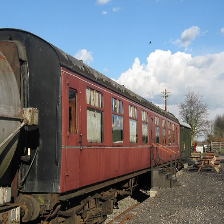

In [11]:
TF.to_pil_image(image_tensor)

In [12]:
boxes, labels, scores = inference_yolo(yolo_model, image_tensor, threshold=0.1, device=device)

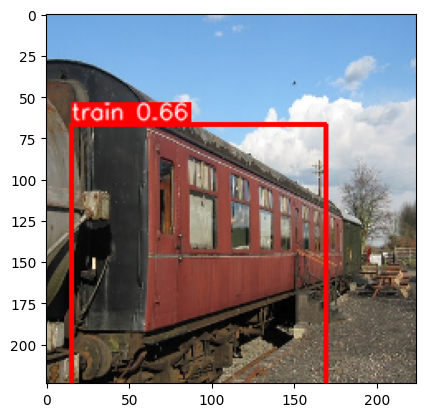

In [13]:
out_img = visualize(image=np.array(TF.to_pil_image(image_tensor)),
    bboxes=boxes,
    category_ids=labels,
    category_id_to_name=val_dataset.idx2label,
    scores=scores
)

plt.imshow(out_img)
plt.show()